<a href="https://colab.research.google.com/github/JakobSchauser/BachelorProject-IceCube-ML/blob/main/Fourth_Working_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install spektral -q

import numpy as np
import tensorflow as tf
import keras
import pickle

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.metrics import MeanAbsoluteError as MeanAbsoluteError_acc
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from spektral.data import DisjointLoader, Dataset
from spektral.datasets import QM9
from spektral.layers import AGNNConv, GlobalSumPool, GCNConv

from tqdm.notebook import tqdm

import wandb
from wandb.keras import WandbCallback

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

PI = np.pi

# Lifehack
true = True
false = False

In [7]:
!pip install wandb -q

import wandb
from wandb.keras import WandbCallback

wandb.login()

True

In [8]:
################################################################################
# LOAD DATA
################################################################################

class dat(Dataset):
  def __init__(self,n = 1,**kwargs):
    self.n = n
    super().__init__(**kwargs)
  def read(self):
    # path = "/content/drive/MyDrive/Bachelor Project - IceCube ML/generatedDataAnglesEnergy100000 0.npz" # Uncleaned
    path = "/content/drive/MyDrive/Bachelor Project - IceCube ML/generatedDataAnglesEnergyClean200000events 0.npz" # Cleaned
    # path = "/content/drive/MyDrive/Bachelor Project - IceCube ML/data.dat" # From Severin
    dataset = np.load(path,allow_pickle = True)["arr_0"]
    graphs = []
    for g in dataset:
      graphs.append(g)
    return np.array(dataset)

dataset = dat()

print("Dataset is", dataset, "consisting of", dataset[0])

# Find the reverse transformer
pcl = "/content/drive/MyDrive/Bachelor Project - IceCube ML/transformers.pkl"

with open(pcl,'rb') as tra:
    transformer = pickle.load(tra)

transformer = transformer["truth"]


#### Put on GPU when possible
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print("Running on GPU")
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("Running on CPU")

Dataset is dat(n_graphs=200000) consisting of Graph(n_nodes=13, n_node_features=5, n_edge_features=None, n_labels=3)
Running on GPU


/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.19.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [9]:
def custom_loss(target,predictions):
    predictions = tf.cast(predictions,"float64")

    energy    = tf.abs(target[:,0] - predictions[:,0])
    azi, zeni = tf.abs(target[:,1] - predictions[:,1]), tf.abs(target[:,2] - predictions[:,2])


    azi  = tf.minimum(azi, tf.abs(tf.abs(azi )-2))     # 2 should be pi or 2pi
    zeni = tf.minimum(tf.abs(zeni), tf.abs(tf.abs(zeni)-2))  # 2 should be pi or 2pi

    # azi, zeni = azi*10,zeni*10

    #Trying something crazy
    # more = 2
    # menergy, mazi, mzeni = tf.where(energy<tf.abs(predictions[:,0]-mean_energy),energy,energy*more), tf.where(azi<tf.abs(predictions[:,1]-mean_azimuth),azi,azi*more), tf.where(zeni<tf.abs(predictions[:,2]-mean_zenith),zeni,zeni*more)
    # energy,azi,zeni = menergy,mazi,mzeni


    loss = 0
    loss += tf.reduce_mean(tf.square(energy))
    loss += tf.reduce_mean(tf.square(azi))
    loss += tf.reduce_mean(tf.square(zeni))
    loss += 0.1
    return loss


################################################################################
# PARAMETERS
################################################################################

config = {
        "learning_rate": 1e-4,
        "epochs": 50*2,
        "batch_size": 64*4,
        "loss_function": "custom_loss",
        "architecture": "Broadening CNN",
        "network_size": 64*2,
        "dataset": "MuonGun"
      }

learning_rate = config["learning_rate"] # Learning rate
epochs = config["epochs"]  # Number of training epochs
test_epochs = 2 # Number of testing epochs
batch_size = config["batch_size"] # Batch size


# Parameters
F = dataset.n_node_features  # Dimension of node features
S = dataset.n_edge_features  # Dimension of edge features
n_out = dataset.n_labels  # Dimension of the target

# Train/test split
idxs = np.random.permutation(len(dataset))
split = int(0.9 * len(dataset))
idx_tr, idx_te = np.split(idxs, [split])
dataset_tr, dataset_te = dataset[idx_tr], dataset[idx_te]

train_loader = DisjointLoader(dataset_tr, batch_size=batch_size, epochs=epochs)
test_loader = DisjointLoader(dataset_te, batch_size=batch_size, epochs=test_epochs, shuffle=True)

In [10]:
network_size =  config["network_size"]# one-variable network size changer

class model_class(Model):
  def __init__(self):
    super().__init__()
    
    steps = [i**2 for i in range(1,5)]

    # self.inp    = AGNNConv()
    self.inp = GCNConv(network_size)
    self.encode = [GCNConv(network_size*s, activation = "relu") for s in steps]
    self.decode = [Dense(network_size*s, activation = "relu") for s in steps[::-1]]
    self.pool   = GlobalSumPool()
    self.out    = Dense(n_out) 

  def call(self, inputs, training = False):
    x, a, i = inputs
    # e    = self.generate_edge_features(x, a)  NEXT STEP is implementing this
    x = self.inp([x,a])

    for enc in self.encode:
      x = enc([x,a])

    for dec in self.decode:
      x = dec(x)
    
    x = self.pool([x,i])

    x_out = self.out(x)

    return x_out

  def generate_edge_features(x,a):
    send    = a.indices[:, 0]
    receive = a.indices[:, 1]

      # forwards  = tf.gather(x[:, 3], send) <= tf.gather(x[:, 3], receive)

      # send    = tf.cast(send[forwards], tf.int64)
      # receive = tf.cast(receive[forwards], tf.int64)

      # a       = SparseTensor(indices = tf.stack([send, receive], axis = 1), values = tf.ones(tf.shape(send), dtype = tf.float32), dense_shape = tf.cast(tf.shape(a), tf.int64))

    diff_x  = tf.subtract(tf.gather(x, receive), tf.gather(x, send))

    dists   = tf.sqrt(
      tf.reduce_sum(
        tf.square(
          diff_x[:, :3]
        ), axis = 1
      ))

    vects = tf.math.divide_no_nan(diff_x[:, :3], tf.expand_dims(dists, axis = -1))

    e = tf.concat([diff_x[:, 3:], tf.expand_dims(dists, -1), vects], axis = 1)

    return a, e


# Build model
model = model_class()

opt = Adam(lr=learning_rate)
loss_fn = custom_loss
# loss_fn = MeanAbsoluteError()
acc_fn = MeanAbsoluteError()


model.compile()
# model.build()

In [11]:
################################################################################
# DEFINE TF-FUNCTIONS
################################################################################
@tf.function(input_signature=train_loader.tf_signature(), experimental_relax_shapes=True)
def train_step(inputs, target):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = loss_fn(target, predictions)
        loss += sum(model.losses)
    gradients = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(gradients, model.trainable_variables))
    acc = acc_fn(target,predictions)

    return loss, acc

def validate(inputs,target):
    predictions = model(inputs, training=False)
    loss = loss_fn(target, predictions)
    loss += sum(model.losses)
    acc = acc_fn(target,predictions)

    return loss, acc

def scale_inputs(inputs):
    inputs[0][:,:3] = inputs[0][:,:3]/100 # x y z
    inputs[0][:,3] = inputs[0][:,3]/10000 # time
    inputs[0][:,4] = inputs[0][:,4]/1 # charge
    return inputs



loss_fn = custom_loss


def fit(train_loader):
  run = wandb.init(project='IceCube GNN Bachelor',config = config)
  current_batch = 0
  model_loss = []
  model_acc = []
  vali_acc = []
  epoch = 0

  epoch_steps = train_loader.steps_per_epoch

  t = tqdm(total  = train_loader.steps_per_epoch,leave = True)
  t.set_description(f'Currently on epoch {0} of {epochs} ')

  pb = []
  tar = []
  step = 0

  last_vali = 0
  for batch in train_loader:
      step += 1
      inputs, target = batch
      inputs = scale_inputs(inputs)

      loss, acc = train_step(inputs,target)

      model_loss.append(loss)
      model_acc.append(acc)
      current_batch += 1
      t.update(1)
      if current_batch == epoch_steps:
          test_loader = DisjointLoader(dataset_te, batch_size=batch_size, epochs=test_epochs, shuffle=True)
          t.set_description(f'Currently validating results')

          for vali_batch in test_loader:
            vali_inputs, vali_target = vali_batch
            valie_inputs = scale_inputs(vali_inputs)
            vali_loss, va = validate(vali_inputs,vali_target)
            vali_acc.append(vali_loss)
          va = np.mean(vali_acc)
          change = (va-last_vali)/max(0.000001,last_vali)
          last_vali = va
          s = "Train loss: {} - Train accuracy: {} | Validation loss {} - Change {:.3}% | Epoch: {}".format(np.mean(model_loss), np.mean(model_acc), va, change*100, epoch)
          t.write(s)
          if epoch%5 == 0 and epoch != 0:
            print("Two current guesses are\n",np.array(pb[0]),np.array(pb[1]),"for\n",tar[0],tar[1])
          else:
            pb = model(inputs, training=False)
            tar = target


          wandb.log({
                    "train_loss": np.mean(model_loss),
                    "train_accuracy": np.mean(model_acc),
                    "val_loss": va,
                    })




          model_loss = []
          model_acc = []
          vali_acc = []
          current_batch = 0
          step = 0

          t.n = 0
          t.last_print_n = 0
          t.refresh()
          epoch += 1

          t.set_description(f'Currently on epoch {epoch} of {epochs} ')


In [ ]:
fit(train_loader)

save_path = "/content/drive/MyDrive/Bachelor Project - IceCube ML/Saved Models"
pth = save_path + "/AnglesEnergy-FourthIteration-100epochs" 
model.save(pth)

Train loss: 12761.311459427072 - Train accuracy: 10.963875770568848 | Validation loss 24.120878408754137 - Change 2.41e+09% | Epoch: 0
Train loss: 280.81453940850247 - Train accuracy: 2.6130998134613037 | Validation loss 2.0531757366862453 - Change -91.5% | Epoch: 1
Train loss: 46.43039998670306 - Train accuracy: 1.5371636152267456 | Validation loss 7.743873638504113 - Change 2.77e+02% | Epoch: 2
Train loss: 151.65882009398945 - Train accuracy: 2.104970932006836 | Validation loss 80.05214050040072 - Change 9.34e+02% | Epoch: 3
Train loss: 26.33665362841322 - Train accuracy: 1.1457997560501099 | Validation loss 18.927871438616 - Change -76.4% | Epoch: 4
Train loss: 143.50247206770064 - Train accuracy: 1.9468026161193848 | Validation loss 7.667238146075797 - Change -59.5% | Epoch: 5
Two current guesses are
 [ 0.11808098  0.2685695  -0.8185601 ] [ 1.2257032   0.16523269 -4.1198726 ] for
 [-0.11122579 -0.73074711 -0.36101879] [ 0.39300252  0.41667691 -0.18376213]
Train loss: 5.058303013708

In [56]:
model.summary()

Model: "model_class_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gcn_conv_25 (GCNConv)        multiple                  320       
_________________________________________________________________
gcn_conv_26 (GCNConv)        multiple                  4096      
_________________________________________________________________
gcn_conv_27 (GCNConv)        multiple                  16384     
_________________________________________________________________
gcn_conv_28 (GCNConv)        multiple                  147456    
_________________________________________________________________
gcn_conv_29 (GCNConv)        multiple                  589824    
_________________________________________________________________
dense_25 (Dense)             multiple                  1049600   
_________________________________________________________________
dense_26 (Dense)             multiple                

Testing model
Done! 
Model loss 0.5655756184694527 | Model accuracy 0.5655756184694527


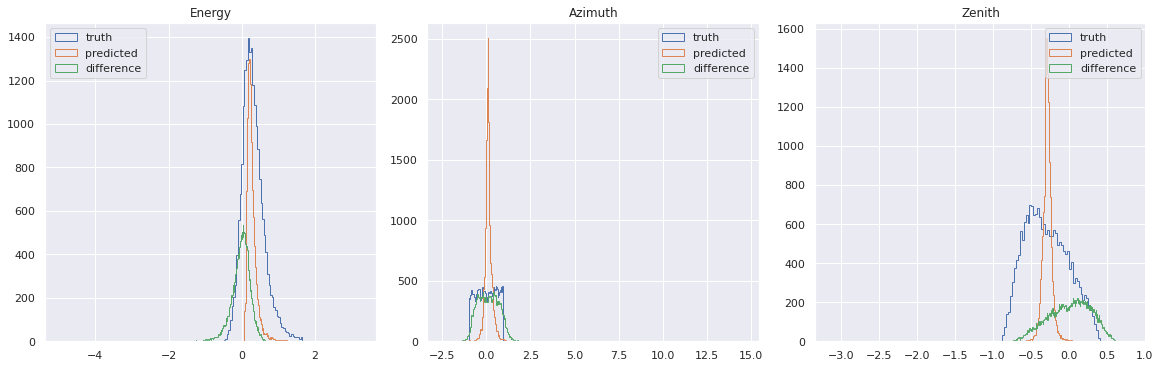

In [64]:
@tf.function(input_signature=test_loader.tf_signature(), experimental_relax_shapes=True)
def get_predictions(inputs,target):
  return model(inputs,training = False)

def make1D(a):
  new = []
  for aa in a:
    for aaa in aa:
      new.append(aaa)
  return np.array(new)

def test_model():
  print("Testing model")
  model_loss, model_acc = [],[]

  test_loader = DisjointLoader(dataset_te, batch_size=batch_size, epochs=1,shuffle = True)

  predictions, truths = [],[]

  for batch in test_loader:
    inputs, target = batch
    inputs = scale_inputs(inputs)
    # print(inputs)
    pred = get_predictions(inputs,target)

    predictions.append(np.array(pred))
    truths.append(np.array(target))

    model_loss.append(loss_fn(target, pred))
    model_acc.append(acc_fn(target, pred))
  
  predictions = make1D(predictions)
  truths      = make1D(truths)

  print(f"Done! \nModel loss {np.mean(model_loss)} | Model accuracy {np.mean(model_loss)}")

  diffs = abs(truths-predictions)
  periodic = abs(abs(truths-predictions)-2)
  diffs = np.minimum(diffs,periodic)

  titles = ["Energy","Azimuth","Zenith"]

  fig, axs = plt.subplots(1,3,figsize=(16,5),constrained_layout=True)


  for i in range(3):
    axs[i].hist(truths[:,i],bins = 50,histtype = "step",label="truth")
    axs[i].hist(predictions[:,i],bins = 500,histtype = "step",label="predicted")
    axs[i].hist((predictions[:,i]-truths[:,i]),bins = 500,histtype = "step",label="difference")

    axs[i].legend()
    axs[i].set_title(titles[i])


test_model()